In [1]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, marker_expression_by_cell_type
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [21]:
# if save session
import dill
dill.dump_session('NKI_notebook_env.db')

In [ ]:
# restore session
import dill
dill.load_session('NKI_notebook_env.db')

## Tidy dataset

Important notes:
- The tables inside the Quantification_table folder are raw signals. Use always log2 for the channels
- The tables inside the Quantification_table folder do not contain cancer cells nor cells with low signal, but the files in Tribus_cell-types/ have those extra cells
- For each call/round of Tribus, perform always outlier truncation, set the maximum to the 99 percentile
- For each call/round of Tribus, perform always Z-score and then Min-Max transformation in all the channels
- The B-cells should be selected during the Global gating using the next threshold: CD20 Z-score >= 3
- The CD15.MY should be selected from the remaining cells which are not Stromal or B-cells gating using the next threshold: CD15 Z-score >= 3; but after all the Tribus calls
- Use the two files cell_type_description, and compare results vs the Globalcelltypes inside the Tribus_cell-types/ folders or in the Quantification_table/ 

In [8]:
# read input files
# TMA_18_810_cellTypes_nonCancerOthers.csv
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\TMA_18_810\\Quantification_table\\TMA_18_810_cellTypes_nonCancerOthers.csv")
sample_data.columns.values

array(['Row_number', 'CoreId', 'CellId', 'DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Perimeter',
       'Roundness', 'X_position', 'Y_position', 'lost', 'Inside_ROI',
       'GlobalCellType', 'out_of_core'], dtype=object)

In [9]:
sample_data = sample_data.fillna(0)
sample_data

,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,CD207,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,8233,102,1,5996.131783,613.848837,202.767442,1026.019380,3365.356589,724.112403,672.434109,...,0.738048,0.973585,56.254,1.024525,1293.205426,494.240310,False,0,Stromal4,False
1,8234,102,2,20252.641975,663.475309,217.061728,925.851852,11023.475309,1599.740741,1117.037037,...,0.613963,0.958580,43.435,1.079059,1401.666667,497.635802,False,0,CD4.T.cells,False
2,8235,102,3,24643.069930,759.559441,250.069930,968.629371,15728.384615,2479.118881,1374.048951,...,0.569576,0.972789,40.342,1.104158,1390.622378,499.783217,False,0,T.regs,False
3,8236,102,4,6507.416667,579.363636,203.018939,1005.147727,3316.916667,773.465909,680.064394,...,0.885397,0.874172,66.914,0.740934,1480.871212,500.056818,False,0,Stromal4,False
4,8237,102,5,11288.340000,760.930000,286.870000,1050.670000,6395.990000,1336.200000,958.760000,...,0.736621,0.952381,36.562,0.940048,1497.100000,502.130000,False,0,Stromal2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460808,779632,9,9584,24447.269504,1670.765957,595.978723,1606.120567,15013.950355,1294.113475,1302.602837,...,0.461481,0.986014,39.896,1.113192,1842.120567,2337.879433,False,0,Stromal3,False
460809,779633,9,9585,22351.607143,1105.863095,383.065476,1167.125000,14113.053571,1621.327381,1421.964286,...,0.717614,0.960000,46.082,0.994161,1736.494048,2338.154762,False,0,CD207.MY,False
460810,779635,9,9587,27756.236641,1250.778626,404.022901,1220.885496,16772.709924,1970.687023,1408.954198,...,0.442473,0.970370,37.646,1.161565,1755.671756,2340.732824,False,0,CD8.CD45RO.T.cells,False
460811,779636,9,9588,18038.486842,1322.504386,673.254386,1521.991228,10789.078947,962.258772,1515.763158,...,0.738995,0.966102,52.814,1.027180,1770.793860,2346.535088,False,0,Stromal4,False


In [10]:
# Use always log2 for the channels
sample_data[['DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 
       'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 
       'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
       'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 
       'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 
       'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 
       'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31']] = sample_data[['DNA1', 'BG488', 'BG555', 
                                                                    'BG647', 'DNA2', 'CD11c', 'CD207', 
                                                                    'GranzymeB', 'DNA3', 'CD163',
                                                                    'CD57', 'CD20', 'DNA4', 'CD4', 
                                                                    'CD3d', 'CD8a', 'DNA5', 'TIM3',
                                                                    'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
                                                                    'FOXP3', 'PD1', 'DNA7',
                                                                    'pTBK1', 'CD68', 'PDL1_2', 
                                                                    'DNA8', 'CD15', 'CD11b', 'yH2AX',
                                                                    'DNA9', 'PDL1_488', 'PDL1_555', 
                                                                    'cPARP1', 'DNA10', 'Ki67',
                                                                    'Vimentin', 'MHCII', 'DNA11', 
                                                                    'LaminB1', 'CK7', 'MHCI', 'DNA12',
                                                                    'ECadherin', 'aSMA', 'CD31']].apply(np.log2)

sample_data[['DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 
       'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 
       'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
       'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 
       'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 
       'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 
       'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31', 'Eccentricity']].describe()

,DNA1,BG488,BG555,BG647,DNA2,CD11c,CD207,GranzymeB,DNA3,CD163,...,MHCII,DNA11,LaminB1,CK7,MHCI,DNA12,ECadherin,aSMA,CD31,Eccentricity
count,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,...,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000,460813.000000
mean,13.655102,9.970207,8.373510,10.121005,13.040971,10.077650,10.185642,11.236778,13.103838,10.245821,...,11.181458,10.750068,10.601107,7.845681,10.586804,10.894960,8.910947,10.716460,10.183714,0.636914
std,0.869705,0.415907,0.466594,0.260538,0.865982,0.798378,0.584612,0.132743,0.879478,0.552592,...,0.955065,1.516113,1.008053,1.439016,1.532260,1.563638,0.168666,1.714442,0.474609,0.157420
min,10.502340,8.338898,6.330855,9.176737,7.233620,8.283256,7.481161,9.976525,7.113370,8.953275,...,10.002055,5.248687,7.964847,4.822730,8.244911,5.491224,8.299028,5.743301,9.477180,0.000000
25%,13.098989,9.688219,8.075196,9.944214,12.493529,9.530816,9.809076,11.158887,12.553426,9.890609,...,10.490500,9.873241,9.850247,6.735789,9.204721,9.999786,8.804745,9.445423,9.920707,0.533680
50%,13.734333,9.897112,8.308705,10.058615,13.126279,9.805319,10.155106,11.208284,13.187037,10.092689,...,10.764799,10.977371,10.612686,7.503384,10.323715,11.124671,8.896852,10.519485,9.989087,0.655375
75%,14.297363,10.180377,8.595339,10.226977,13.689732,10.383947,10.517433,11.281146,13.754763,10.403763,...,11.570675,11.852620,11.351520,8.646313,11.782043,12.032949,9.002532,11.957934,10.224804,0.758134
max,15.907767,13.662836,15.205711,14.146486,15.581502,15.103269,15.783817,15.742244,15.953442,14.739859,...,15.975378,15.436476,14.642383,14.247537,15.584546,15.647044,10.101968,15.989473,14.302792,0.973968


In [11]:
# perform always outlier truncation, set the maximum to the 99 percentile
cols = ['DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 
       'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 
       'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
       'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 
       'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 
       'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 
       'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31', 'Eccentricity']

Q = sample_data[cols].quantile(0.99)

sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
sample_data

,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,CD207,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,8233,102,1,12.549816,9.261740,7.663682,10.002842,11.716544,9.500070,9.393249,...,0.738048,0.973585,56.254,1.024525,1293.205426,494.240310,False,0,Stromal4,False
1,8234,102,2,14.305823,9.373899,7.761962,9.854638,13.428292,10.643622,10.125461,...,0.613963,0.958580,43.435,1.079059,1401.666667,497.635802,False,0,CD4.T.cells,False
3,8236,102,4,12.667869,9.178325,7.665471,9.973192,11.695627,9.595194,9.409528,...,0.885397,0.874172,66.914,0.740934,1480.871212,500.056818,False,0,Stromal4,False
4,8237,102,5,13.462546,9.571620,8.164253,10.037094,12.642952,10.383920,9.905026,...,0.736621,0.952381,36.562,0.940048,1497.100000,502.130000,False,0,Stromal2,False
5,8238,102,6,13.944867,9.831594,8.320359,10.220247,13.148234,9.905234,10.296891,...,0.756942,0.901961,45.296,0.845219,1505.521739,503.152174,False,0,Stromal3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460807,779631,9,9583,11.941211,9.382974,8.282087,10.470040,11.272133,9.644855,9.969406,...,0.423043,1.000000,28.202,1.169181,1625.337838,2337.810811,False,0,Stromal4,False
460808,779632,9,9584,14.577386,10.706294,9.219117,10.649364,13.874016,10.337748,10.347182,...,0.461481,0.986014,39.896,1.113192,1842.120567,2337.879433,False,0,Stromal3,False
460809,779633,9,9585,14.448091,10.110957,8.581447,10.188743,13.784743,10.662960,10.473670,...,0.717614,0.960000,46.082,0.994161,1736.494048,2338.154762,False,0,CD207.MY,False
460810,779635,9,9587,14.760524,10.288611,8.658293,10.253712,14.033828,10.944483,10.460409,...,0.442473,0.970370,37.646,1.161565,1755.671756,2340.732824,False,0,CD8.CD45RO.T.cells,False


In [16]:
# For each call/round of Tribus 
# perform always Z-score and then Min-Max transformation in all the channels
# z-score
sample_data_scale = sample_data
cols = ['DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 
       'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 
       'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
       'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 
       'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 
       'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 
       'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31']
sample_data_scale.loc[:,(cols)] = sample_data_scale[cols].apply(stats.zscore, nan_policy='omit')
# define min max scaler
scaler = MinMaxScaler()
sample_data_scale.loc[:,(cols)] = scaler.fit_transform(sample_data_scale[cols])
sample_data_scale

,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,CD207,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,8233,102,1,0.426617,0.317324,0.377706,0.442754,0.608471,0.279548,0.443597,...,0.738048,0.973585,56.254,1.024525,1293.205426,494.240310,False,0,Stromal4,False
1,8234,102,2,0.793246,0.355891,0.405557,0.363323,0.840808,0.542265,0.613468,...,0.613963,0.958580,43.435,1.079059,1401.666667,497.635802,False,0,CD4.T.cells,False
3,8236,102,4,0.451265,0.288642,0.378212,0.426863,0.605632,0.301401,0.447374,...,0.885397,0.874172,66.914,0.740934,1480.871212,500.056818,False,0,Stromal4,False
4,8237,102,5,0.617182,0.423879,0.519561,0.461112,0.734214,0.482602,0.562328,...,0.736621,0.952381,36.562,0.940048,1497.100000,502.130000,False,0,Stromal2,False
5,8238,102,6,0.717884,0.513272,0.563799,0.559273,0.802796,0.372629,0.653239,...,0.756942,0.901961,45.296,0.845219,1505.521739,503.152174,False,0,Stromal3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460807,779631,9,9583,0.299550,0.359012,0.552953,0.693151,0.548151,0.312810,0.577264,...,0.423043,1.000000,28.202,1.169181,1625.337838,2337.810811,False,0,Stromal4,False
460808,779632,9,9584,0.849945,0.814043,0.818495,0.789260,0.901307,0.471994,0.664906,...,0.461481,0.986014,39.896,1.113192,1842.120567,2337.879433,False,0,Stromal3,False
460809,779633,9,9585,0.822950,0.609333,0.637788,0.542389,0.889190,0.546707,0.694251,...,0.717614,0.960000,46.082,0.994161,1736.494048,2338.154762,False,0,CD207.MY,False
460810,779635,9,9587,0.888181,0.670420,0.659565,0.577209,0.922999,0.611384,0.691174,...,0.442473,0.970370,37.646,1.161565,1755.671756,2340.732824,False,0,CD8.CD45RO.T.cells,False


In [24]:
sample_data_scale.to_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\input_data\\TMA_18_810_cellTypes_nonCancerOthers_scaled.csv")

## Check marker quality

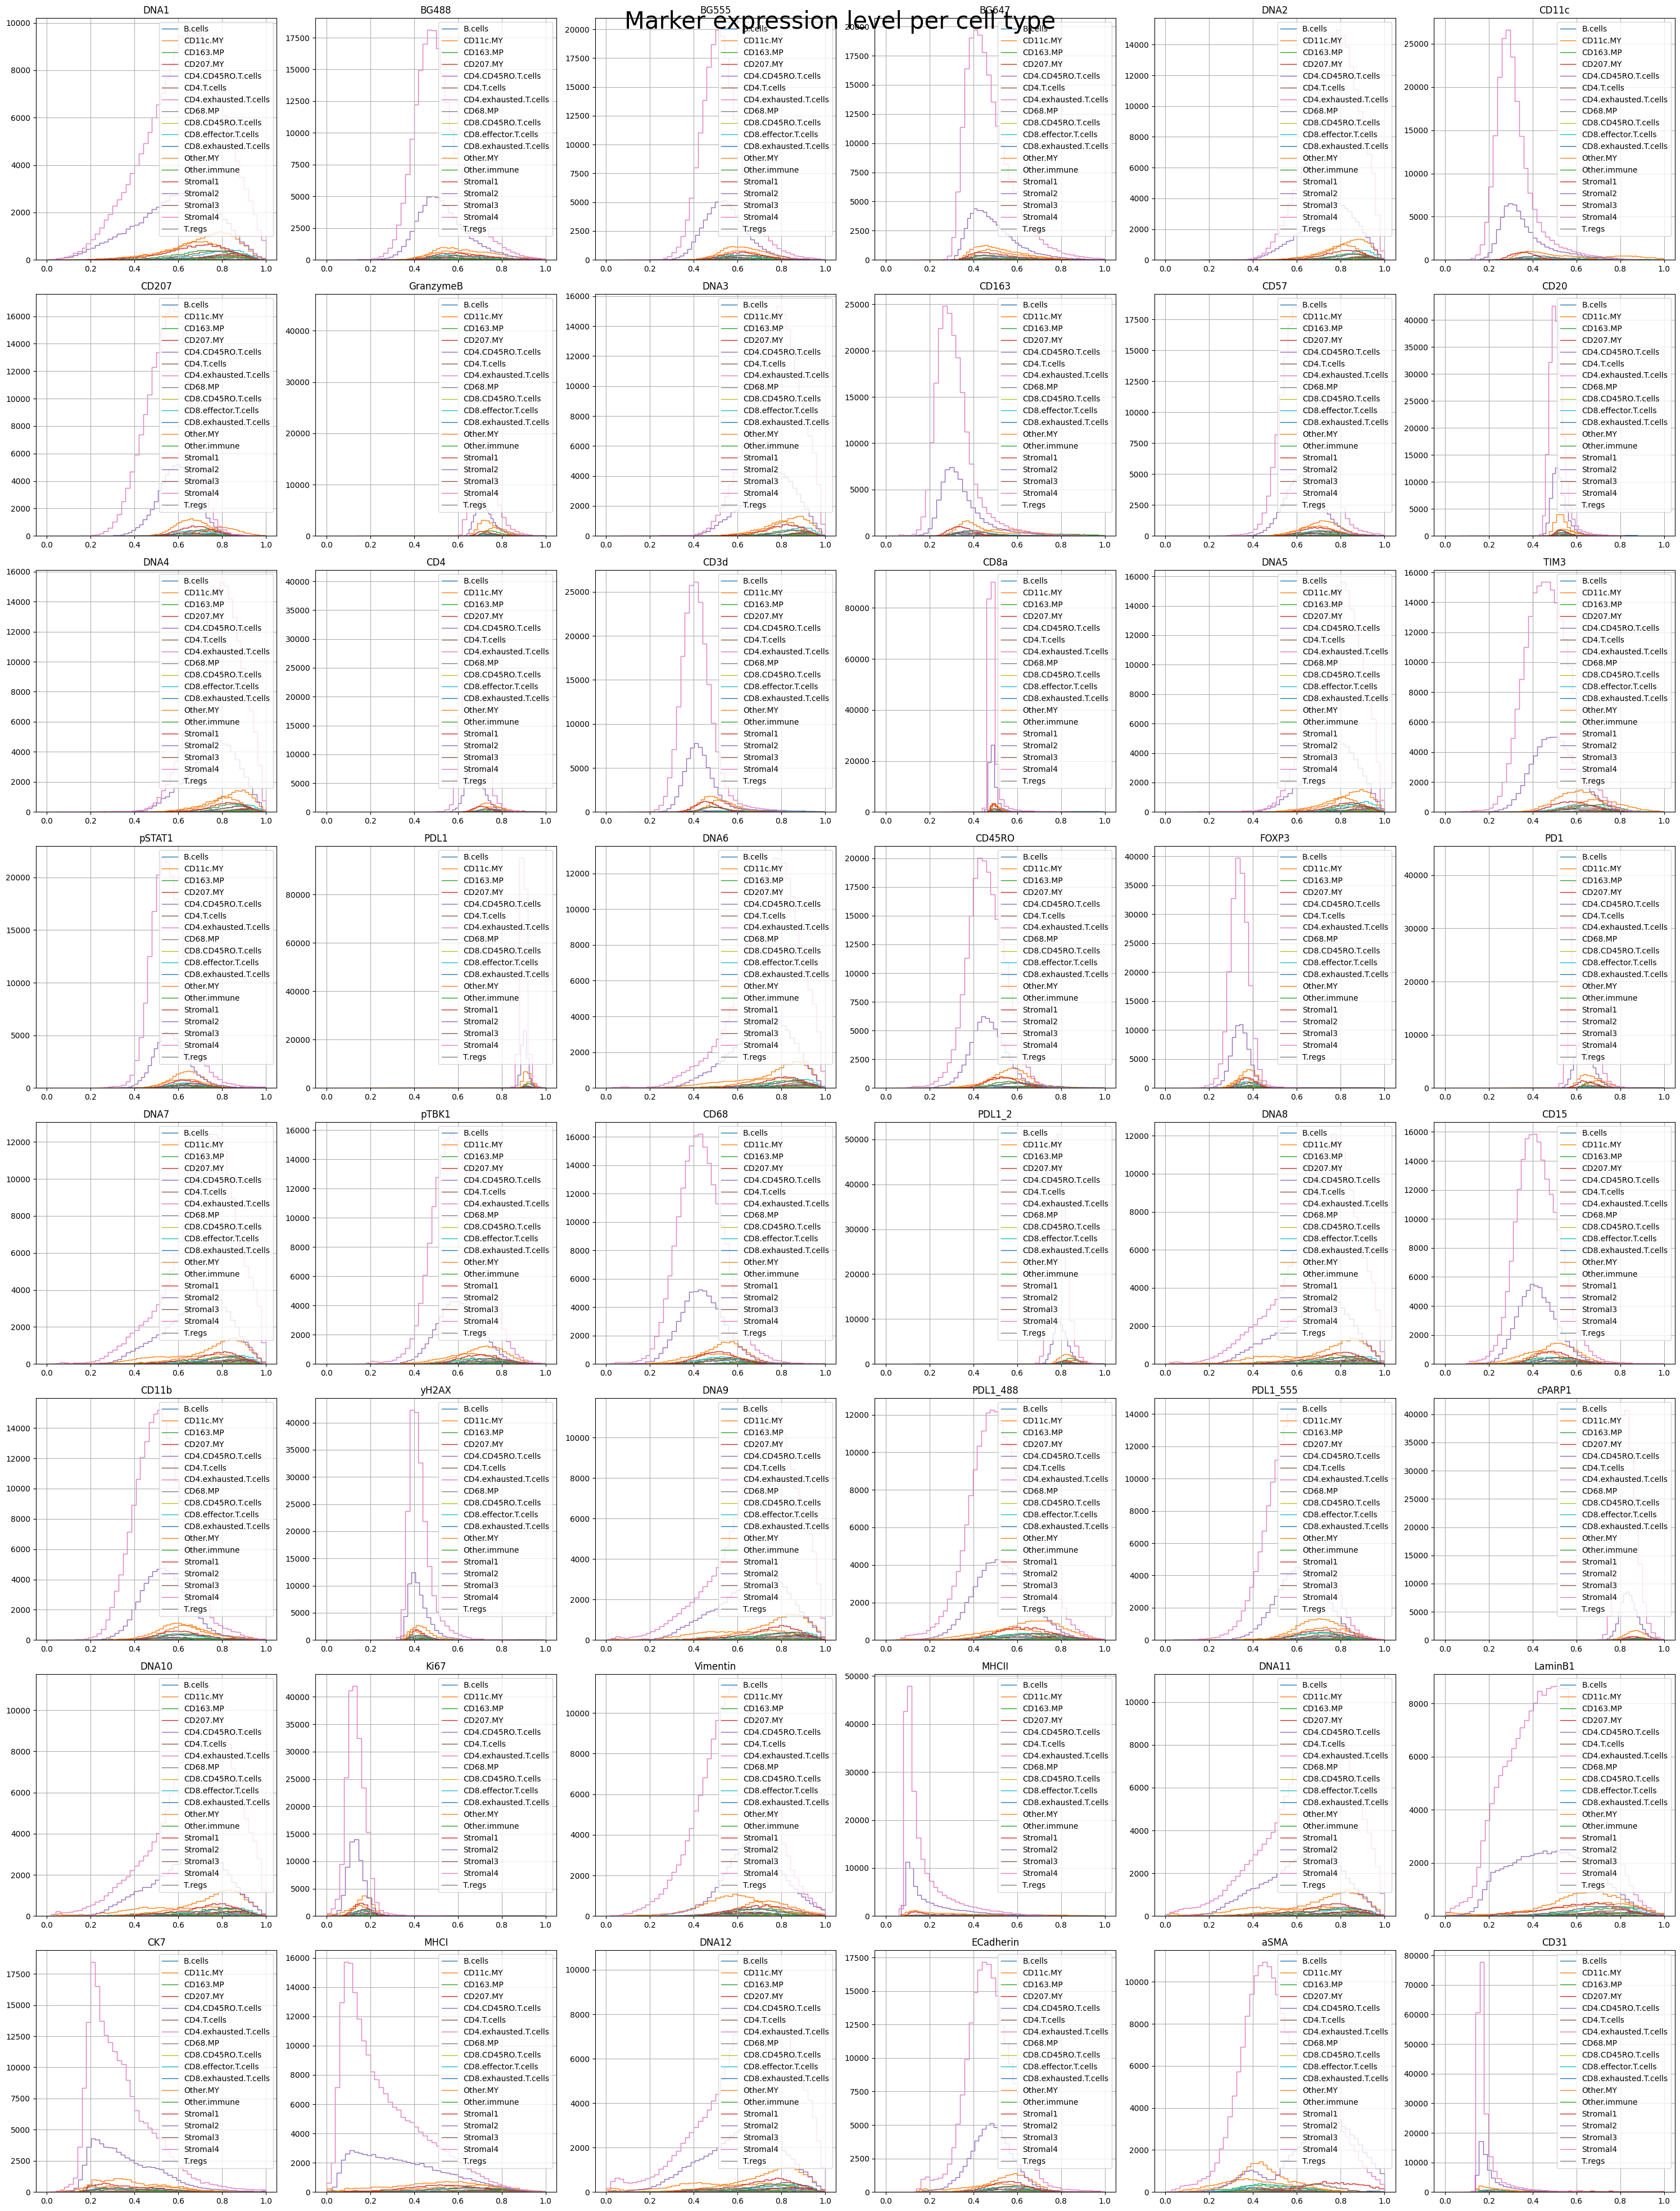

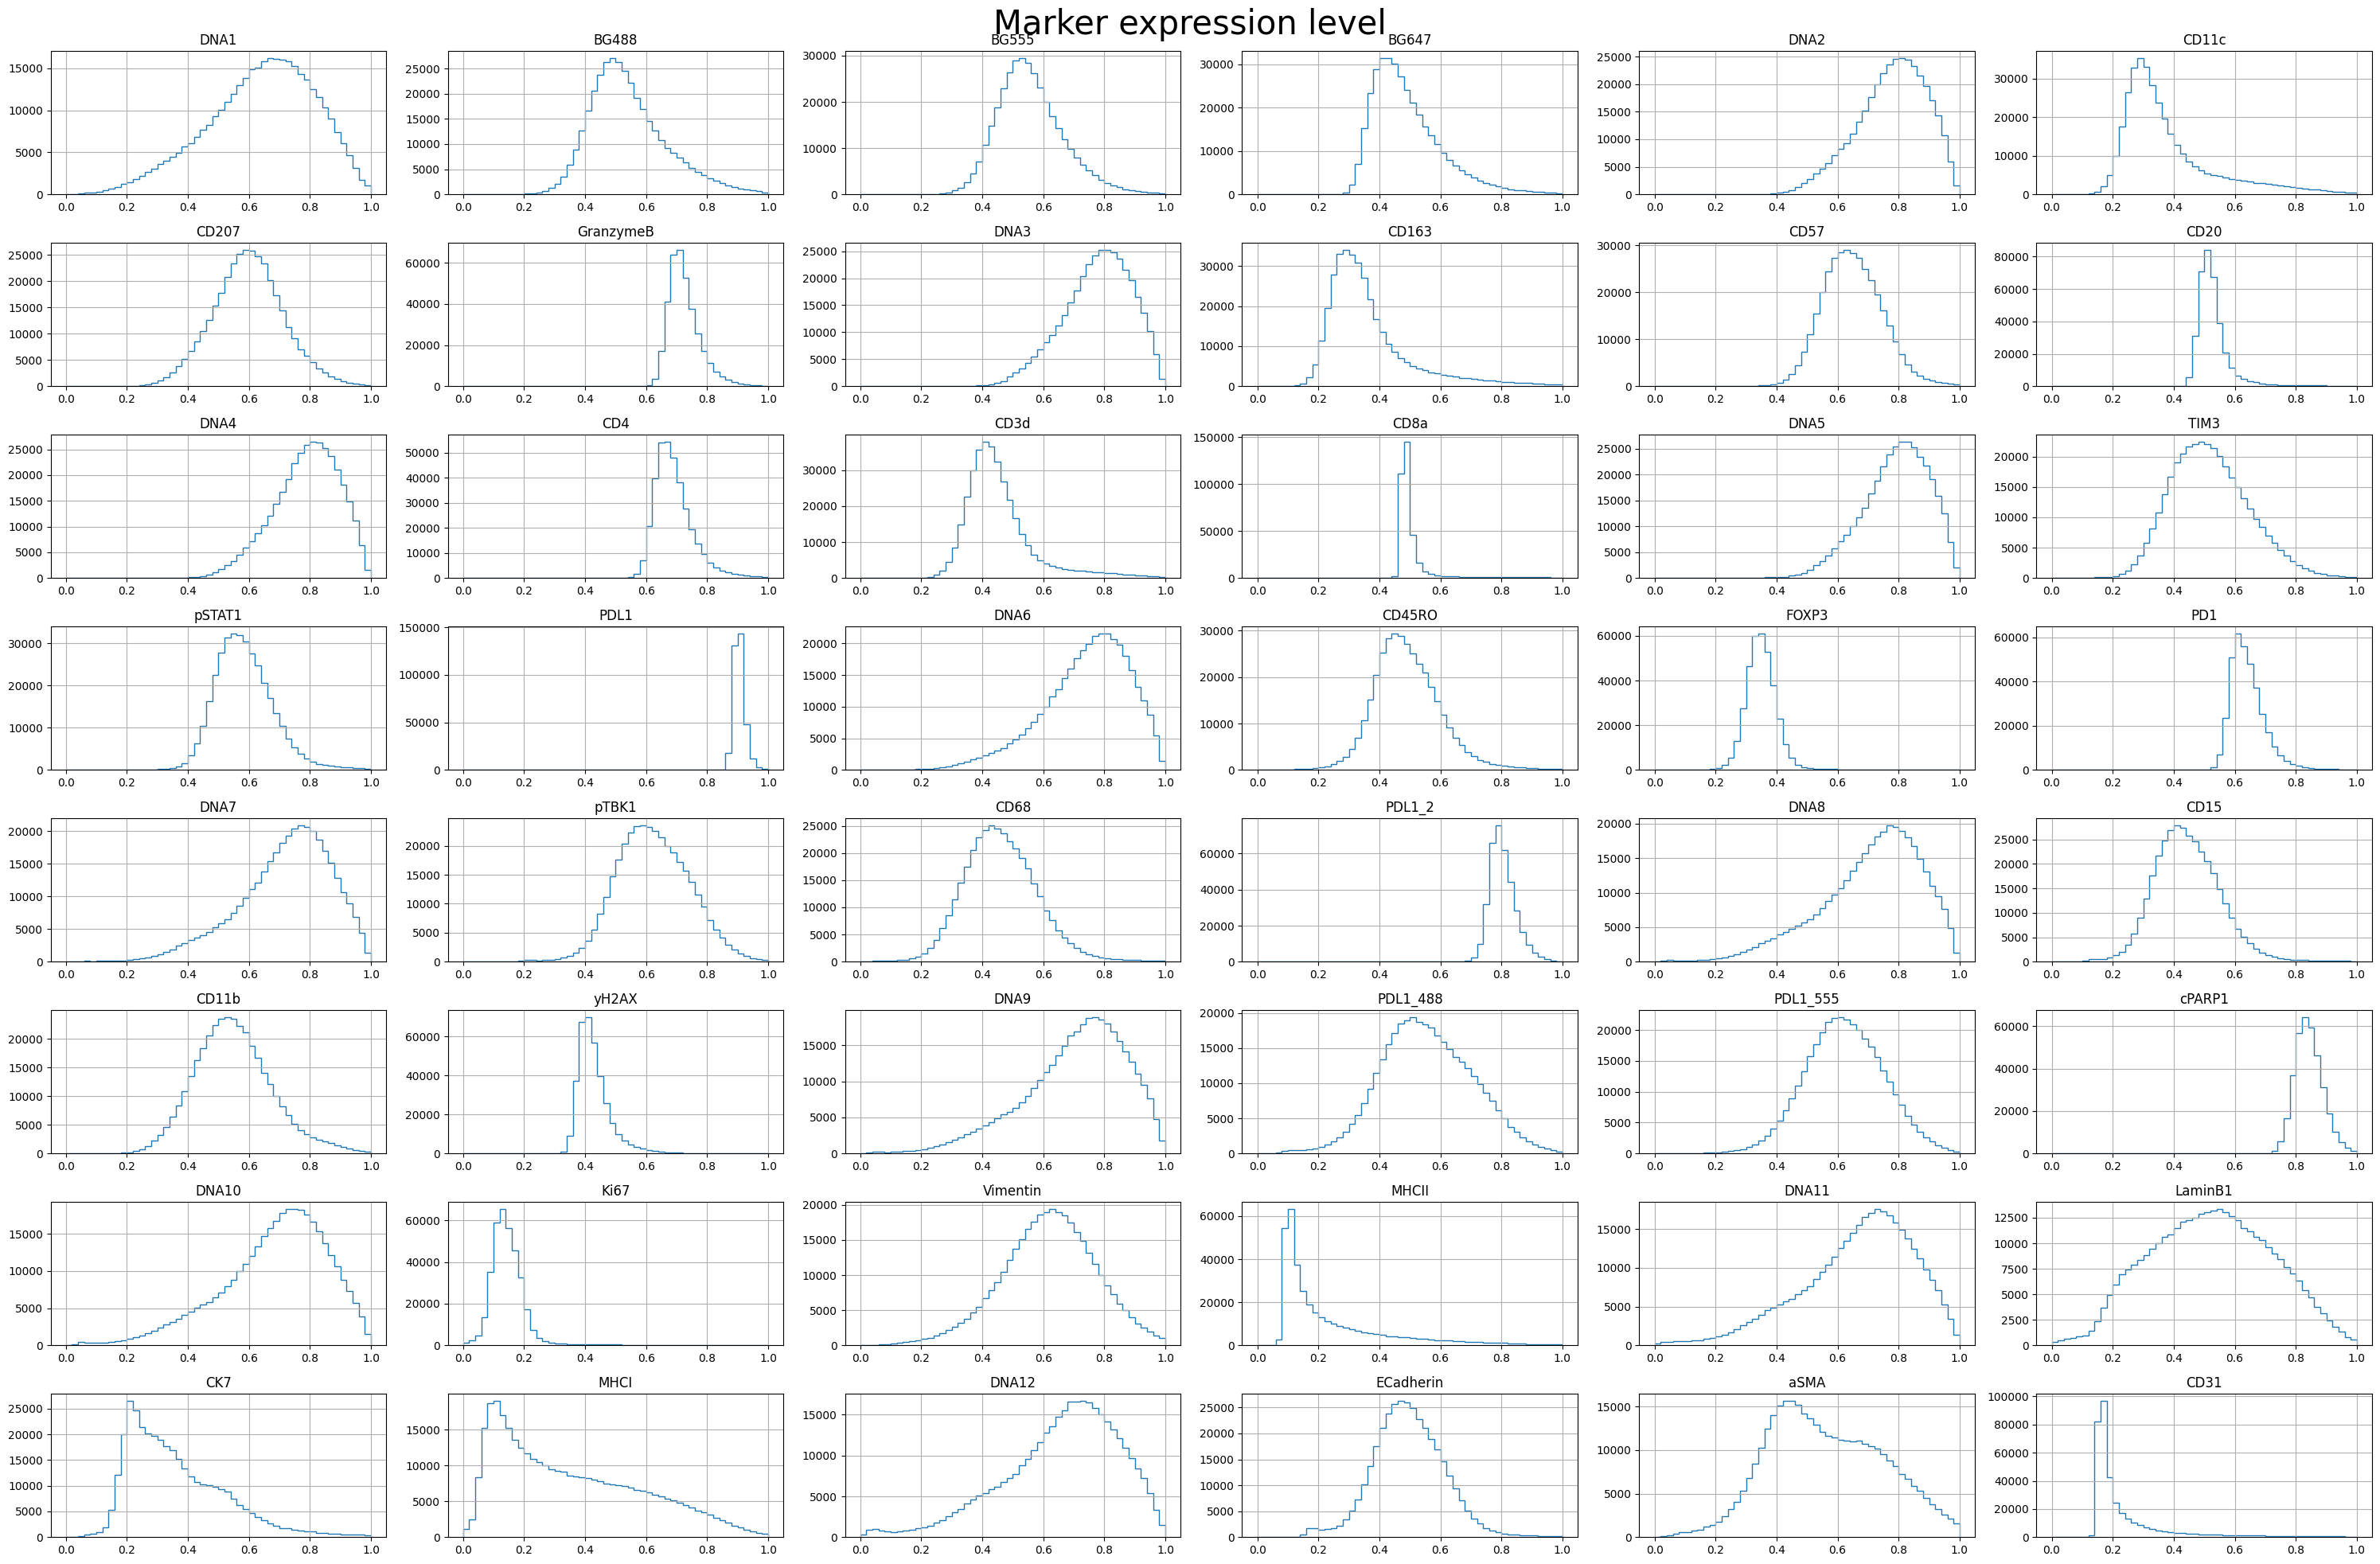

In [8]:
sample_data_scale = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\input_data\\TMA_18_810_cellTypes_nonCancerOthers_scaled.csv")

cols = ['DNA1', 'BG488', 'BG555',
       'BG647', 'DNA2', 'CD11c', 'CD207', 
       'GranzymeB', 'DNA3', 'CD163',
       'CD57', 'CD20', 'DNA4', 'CD4', 
       'CD3d', 'CD8a', 'DNA5', 'TIM3',
       'pSTAT1', 'PDL1', 'DNA6', 'CD45RO', 
       'FOXP3', 'PD1', 'DNA7',
       'pTBK1', 'CD68', 'PDL1_2', 
       'DNA8', 'CD15', 'CD11b', 'yH2AX',
       'DNA9', 'PDL1_488', 'PDL1_555', 
       'cPARP1', 'DNA10', 'Ki67',
       'Vimentin', 'MHCII', 'DNA11', 
       'LaminB1', 'CK7', 'MHCI', 'DNA12',
       'ECadherin', 'aSMA', 'CD31']

label = {'Global': sample_data_scale['GlobalCellType']}
label = pd.DataFrame(label)

markers = sample_data_scale[cols].columns.values
sample_data_labeled = sample_data.copy()
sample_data_labeled["label"] = label["Global"]
cell_types = np.unique(sample_data_labeled["label"])

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 40))
fig.suptitle("Marker expression level per cell type", fontsize=30)

for i in range(len(markers)):
    ax = axs[i//6, i%6]
    plt.sca(ax)
    for uc in cell_types:
        subset = sample_data_labeled.loc[sample_data_labeled["label"]==uc]
        hist, edges = np.histogram(subset[markers[i]], bins=50)
        plt.stairs(hist+sys.float_info.epsilon, edges, label="{}".format(uc))
        plt.legend(loc='upper right')
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

marker_expression(sample_data_scale[cols], markers=None, save=False, fname=None, dpi='figure', log=False)

## Run Tribus with cell type description 1

In [2]:
# read input files
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\input_data\\TMA_18_810_cellTypes_nonCancerOthers_scaled.csv")
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\cell_type_descriptions1.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data

,Unnamed: 0,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,0,8233,102,1,0.426617,0.317324,0.377706,0.442754,0.608471,0.279548,...,0.738048,0.973585,56.254,1.024525,1293.205426,494.240310,False,0,Stromal4,False
1,1,8234,102,2,0.793246,0.355891,0.405557,0.363323,0.840808,0.542265,...,0.613963,0.958580,43.435,1.079059,1401.666667,497.635802,False,0,CD4.T.cells,False
2,3,8236,102,4,0.451265,0.288642,0.378212,0.426863,0.605632,0.301401,...,0.885397,0.874172,66.914,0.740934,1480.871212,500.056818,False,0,Stromal4,False
3,4,8237,102,5,0.617182,0.423879,0.519561,0.461112,0.734214,0.482602,...,0.736621,0.952381,36.562,0.940048,1497.100000,502.130000,False,0,Stromal2,False
4,5,8238,102,6,0.717884,0.513272,0.563799,0.559273,0.802796,0.372629,...,0.756942,0.901961,45.296,0.845219,1505.521739,503.152174,False,0,Stromal3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357231,460807,779631,9,9583,0.299550,0.359012,0.552953,0.693151,0.548151,0.312810,...,0.423043,1.000000,28.202,1.169181,1625.337838,2337.810811,False,0,Stromal4,False
357232,460808,779632,9,9584,0.849945,0.814043,0.818495,0.789260,0.901307,0.471994,...,0.461481,0.986014,39.896,1.113192,1842.120567,2337.879433,False,0,Stromal3,False
357233,460809,779633,9,9585,0.822950,0.609333,0.637788,0.542389,0.889190,0.546707,...,0.717614,0.960000,46.082,0.994161,1736.494048,2338.154762,False,0,CD207.MY,False
357234,460810,779635,9,9587,0.888181,0.670420,0.659565,0.577209,0.922999,0.611384,...,0.442473,0.970370,37.646,1.161565,1755.671756,2340.732824,False,0,CD8.CD45RO.T.cells,False


In [3]:
logic

{'Global':           Stromal  Myeloid  Lymphoid
 Marker                              
 aSMA            1       -1        -1
 Vimentin        1       -1        -1
 CD31            1        0         0
 MHCII           0        1         0
 CD163          -1        1         0
 CD11b           0        1         0
 CD11c          -1        1         0
 CD68            0        1         0
 CD207          -1        1         0
 CD3d           -1       -1         1
 CD4             0        0         1
 CD8a            0        0         1,
 'Myeloid':         CD163+MP  CD207+MY  CD68+MP  CD11c+MP
 Marker                                       
 CD163          1        -1       -1        -1
 CD207          0         1       -1         0
 CD11c         -1        -1       -1         1
 CD68           0         0        1         0,
 'Lymphoid':         CD8+Tcells  CD4+Tcells
 Marker                        
 CD4             -1           1
 CD3d             1           1
 CD8a             1    

In [4]:
# Run Tribus on already z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=3, normalization=None) # modify depth

Global, subsetting done
Myeloid, subsetting done
Lymphoid, subsetting done
CD8+Tcells, subsetting done
CD4+Tcells, subsetting done
22.80696185827255 minutes


<BarContainer object of 18 artists>

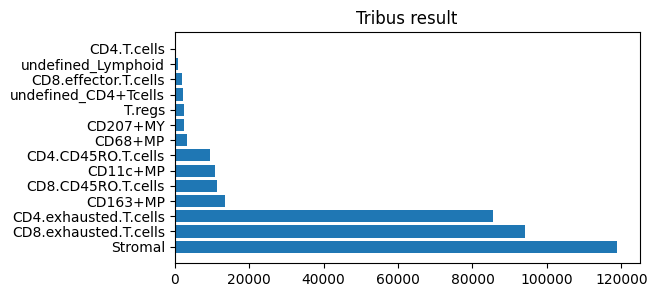

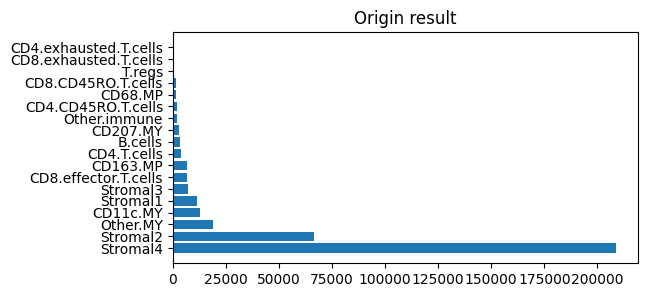

In [5]:
label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Tribus result')
ax.barh(name, num)

label_stat = pd.DataFrame({'Group': sample_data['GlobalCellType']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
name = label_stat['Group']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Origin result')
ax.barh(name, num)

          Lymphoid   Myeloid   Stromal
aSMA      0.457070  0.537761  0.738049
Vimentin  0.584071  0.708071  0.661014
CD31      0.170131  0.256814  0.184706
MHCII     0.157097  0.621145  0.131153
CD163     0.330127  0.606147  0.300685
CD11b     0.536219  0.635789  0.524565
CD11c     0.331693  0.650664  0.306216
CD68      0.461745  0.554755  0.424739
CD207     0.592147  0.723093  0.578052
CD3d      0.436126  0.505539  0.407908
CD4       0.683641  0.759536  0.663295
CD8a      0.487351  0.502058  0.483933


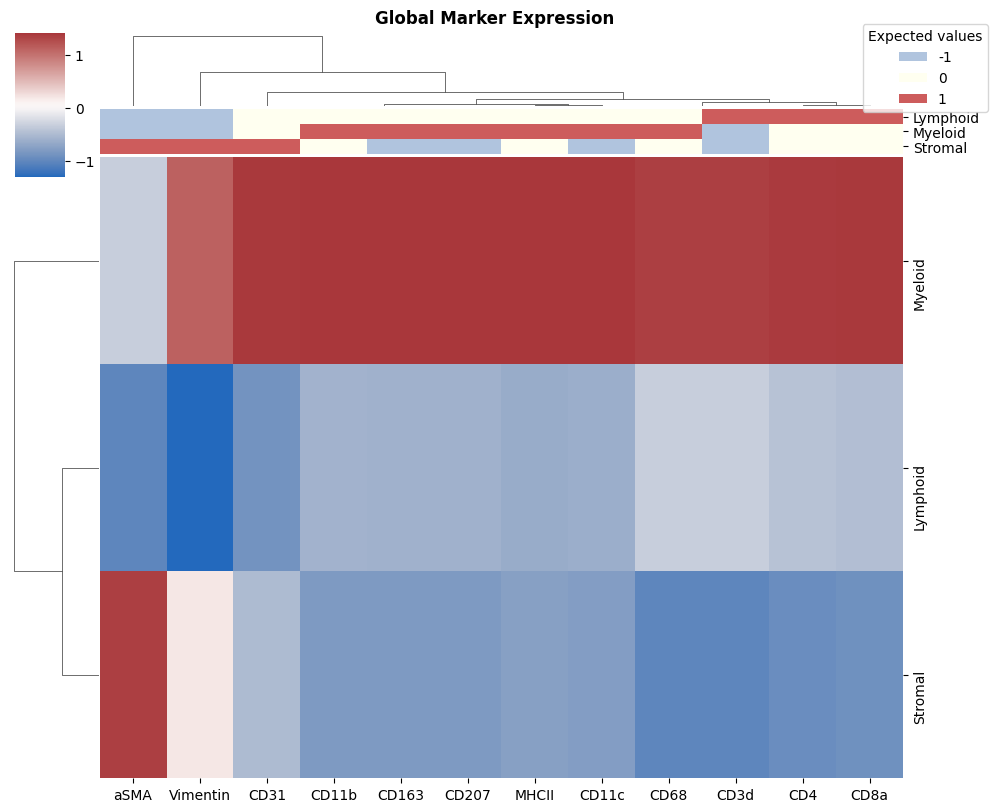

       CD11c+MP  CD163+MP  CD207+MY   CD68+MP
CD163  0.547802  0.738016  0.456684  0.461313
CD207  0.776565  0.705732  0.737453  0.648995
CD11c  0.770790  0.605750  0.568508  0.534709
CD68   0.536738  0.555712  0.539660  0.625330


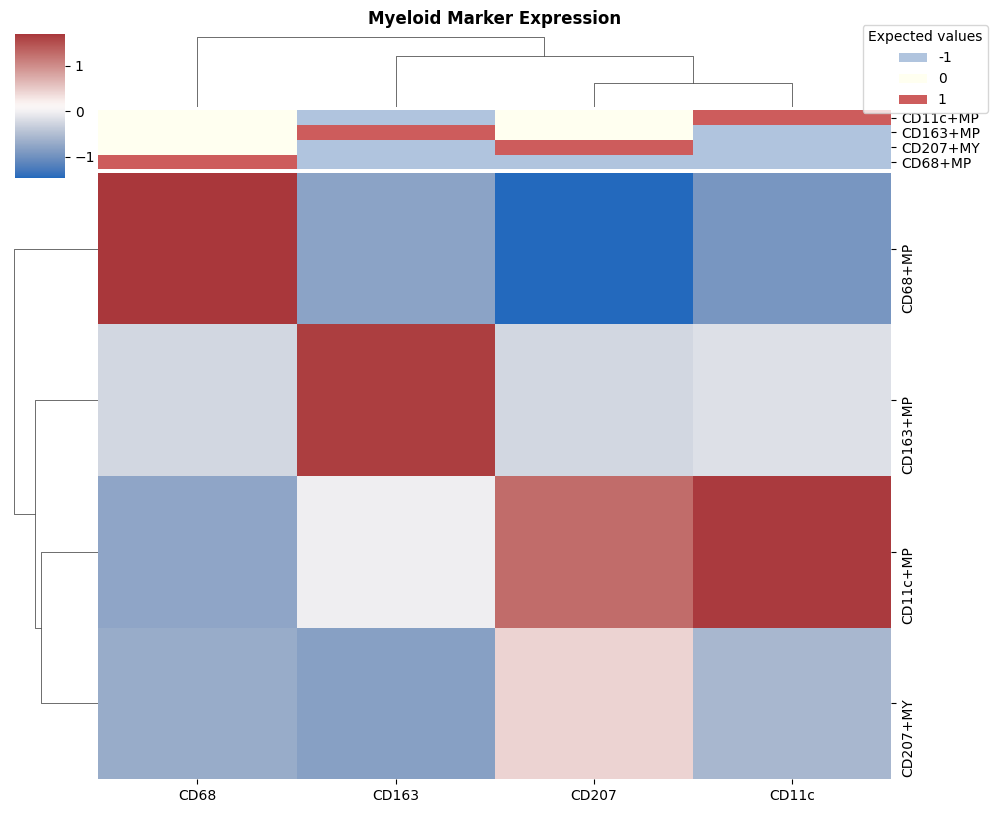

       CD4+Tcells  CD8+Tcells
CD4      0.718268    0.650058
CD3d     0.467611    0.401086
CD8a     0.494126    0.480331
FOXP3    0.376418    0.324870


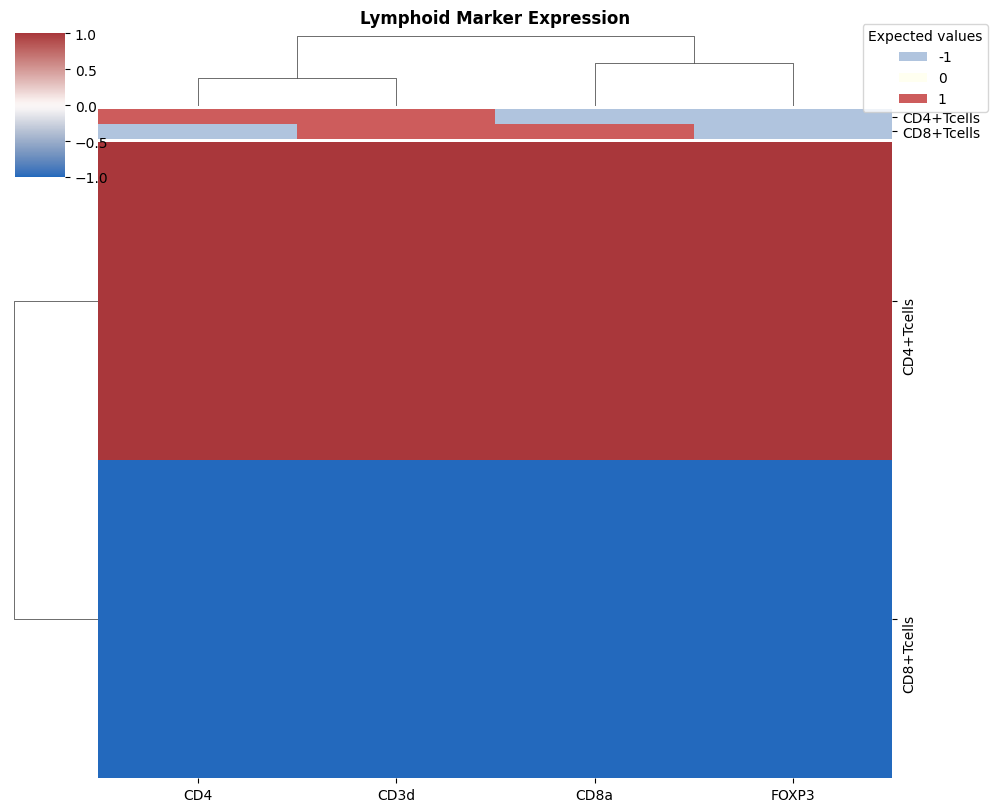

        CD8.CD45RO.T.cells  CD8.effector.T.cells  CD8.exhausted.T.cells
CD8a              0.656257              0.805743               0.479275
PD1               0.633112              0.617250               0.620849
CD45RO            0.583055              0.392855               0.421677


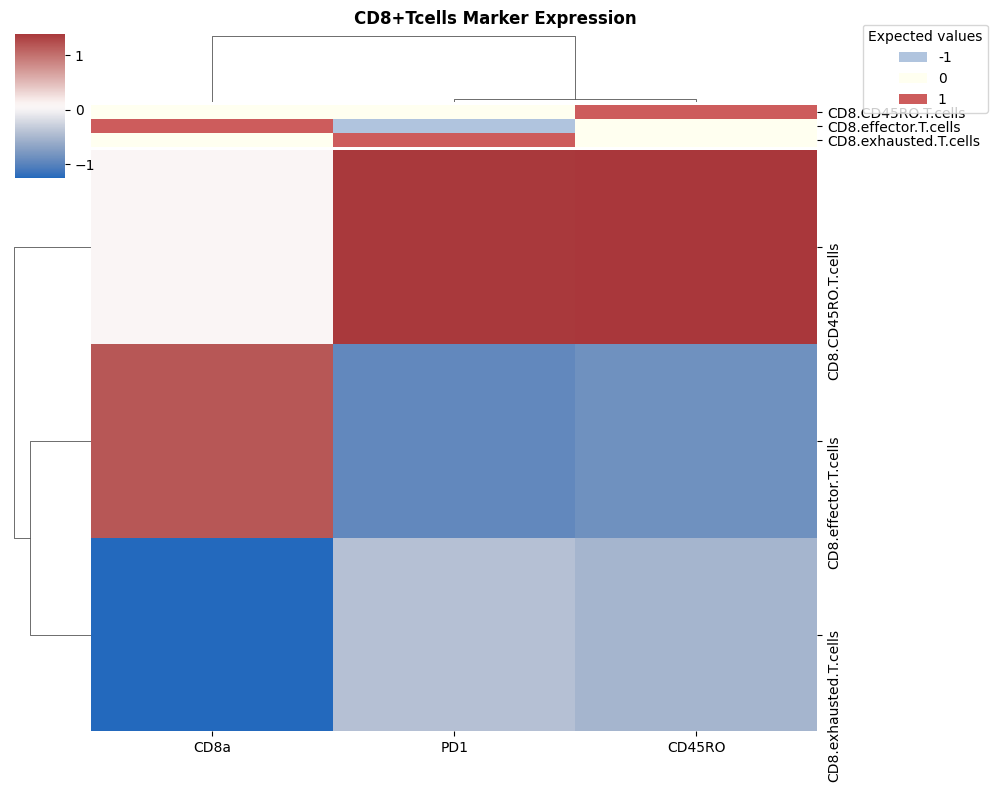

        CD4.CD45RO.T.cells  CD4.T.cells  CD4.exhausted.T.cells    T.regs
FOXP3             0.415229     0.162534               0.370705  0.782157
PD1               0.640828     0.319627               0.639230  0.710362
CD45RO            0.681629     0.143186               0.541592  0.683215
CD4               0.768926     0.693374               0.712925  0.827433


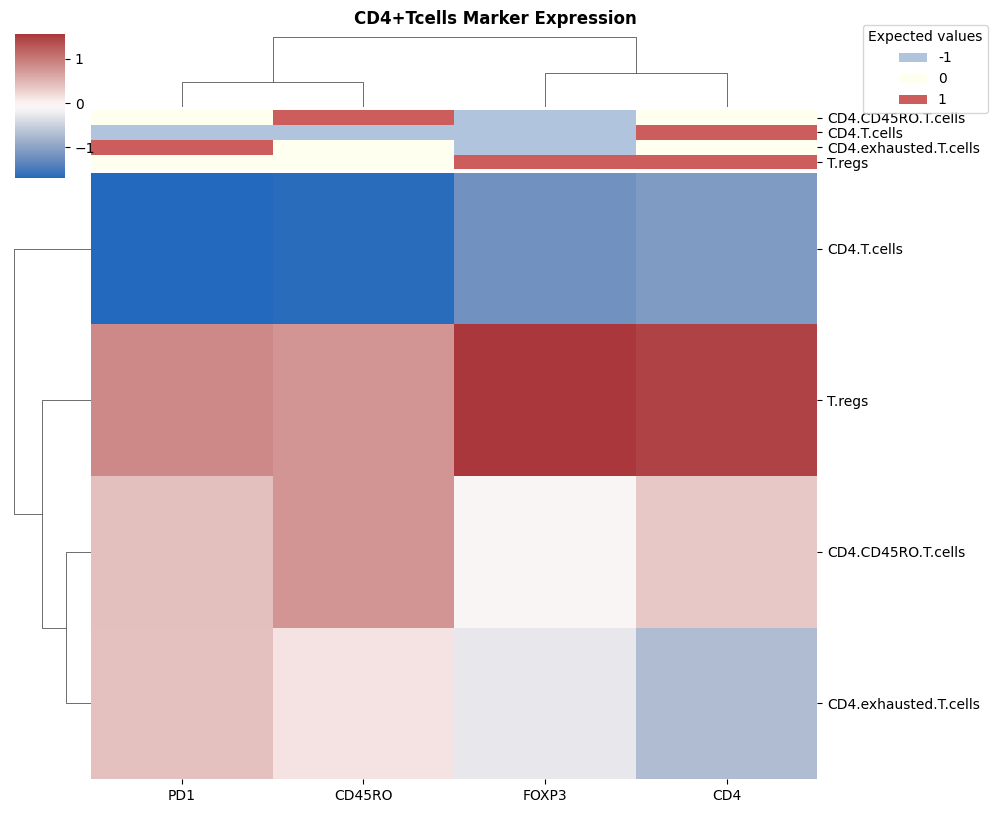

In [6]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False, fname=None,
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)


C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_22356\4218788883.py:28: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Text(158.08159722222223, 0.5, 'True')

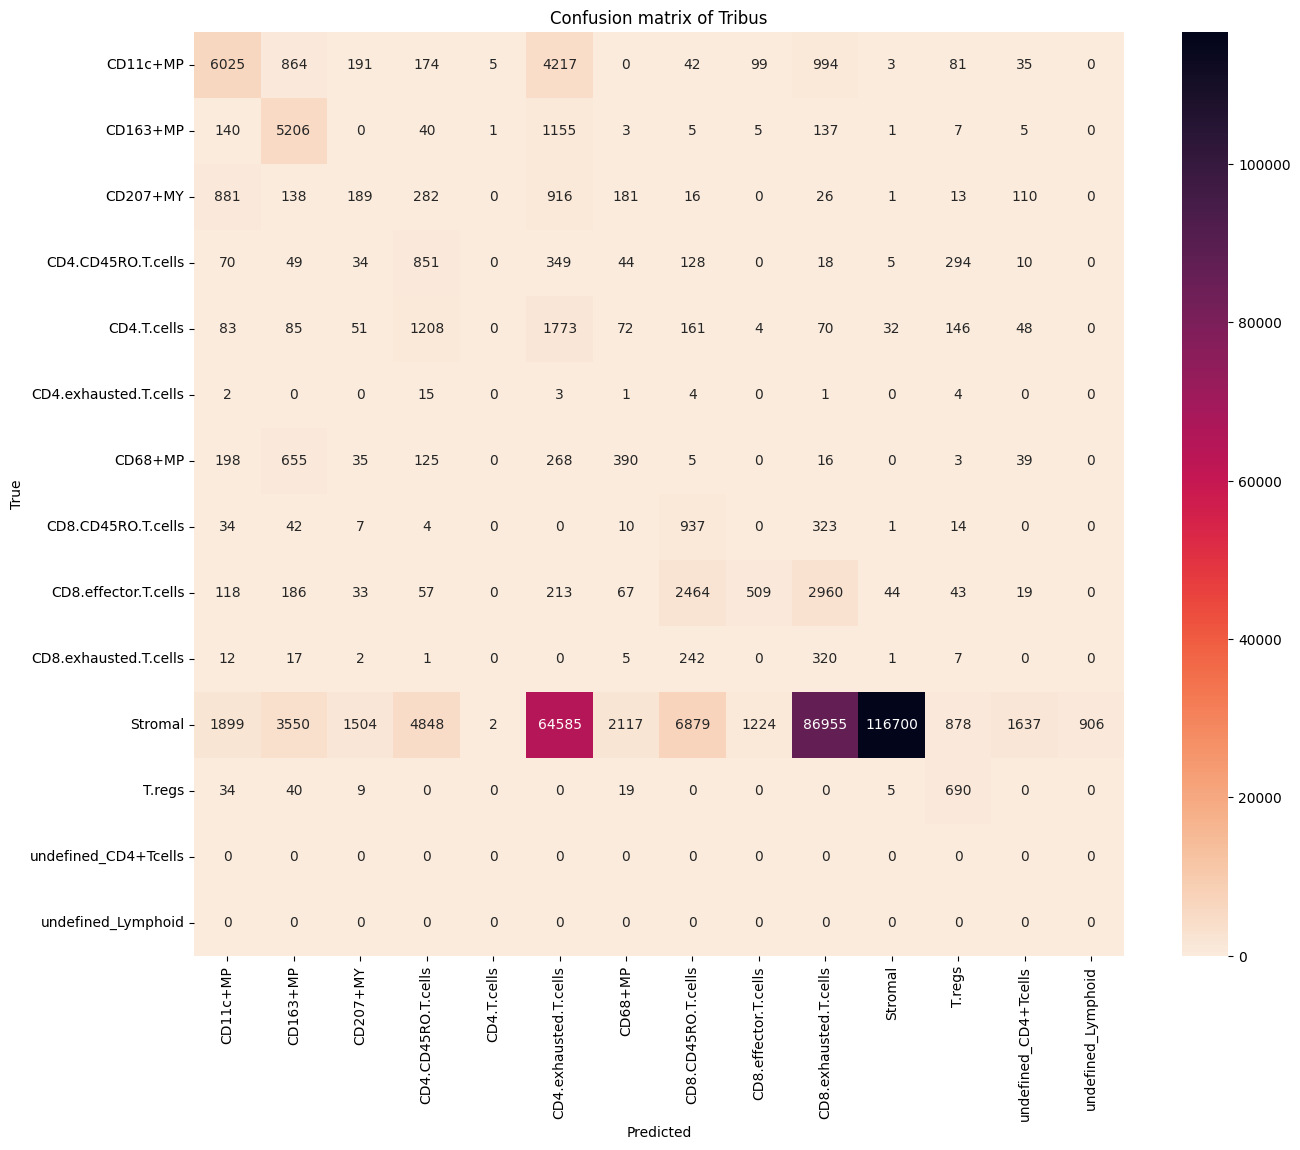

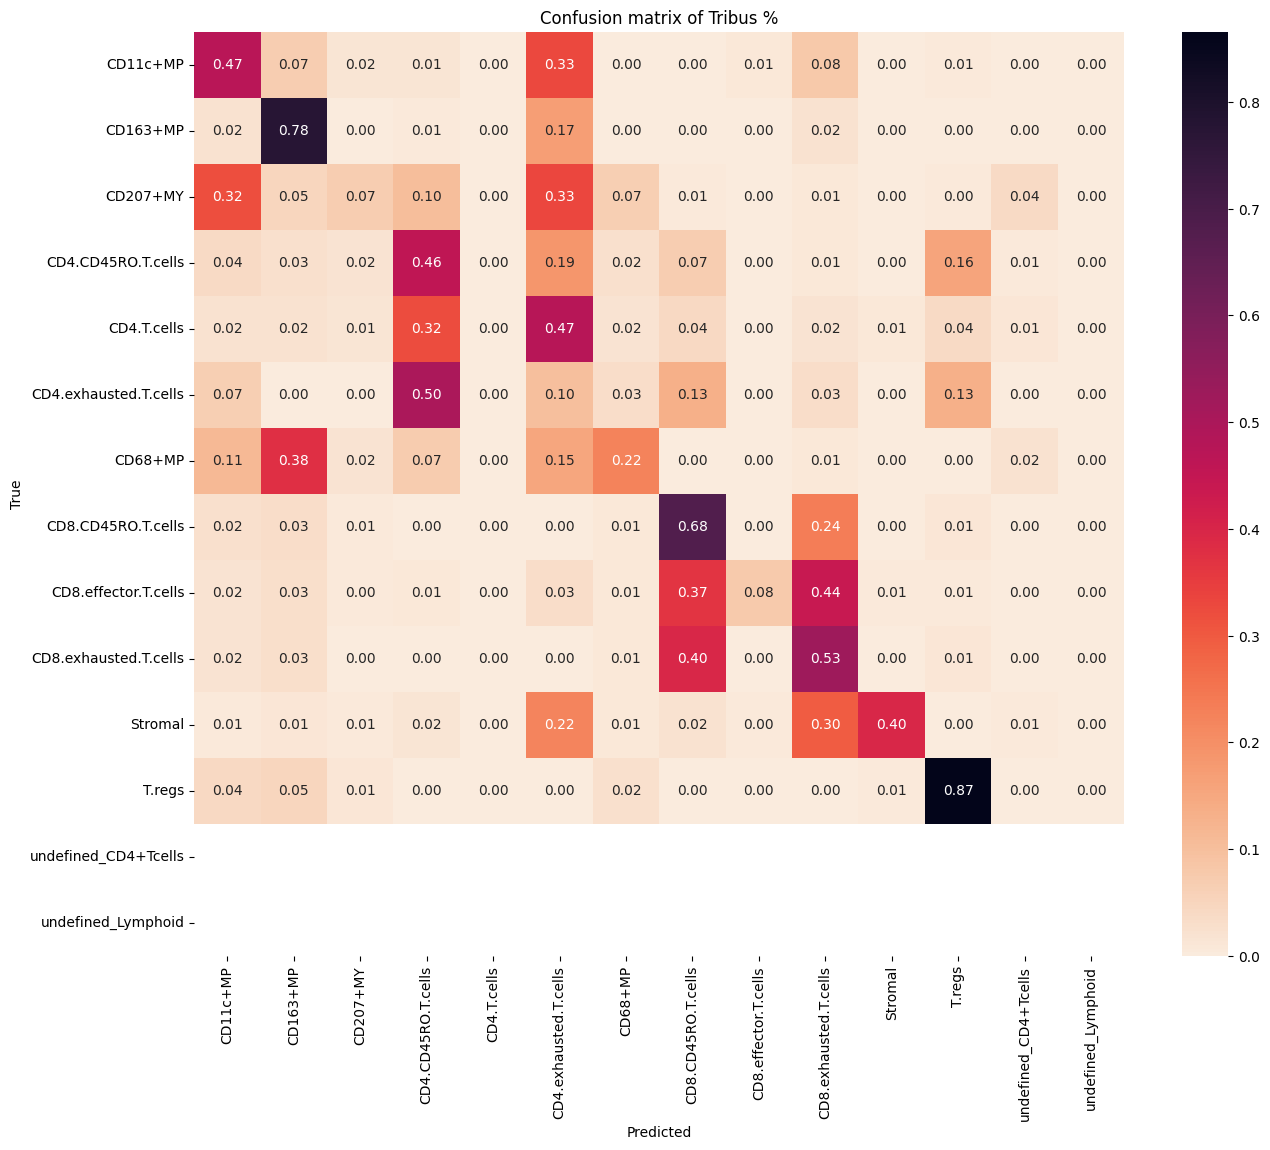

In [11]:
# confusion matrix
celltype_true = np.array(sample_data["GlobalCellType"]).tolist()

celltype_true = [element.replace('CD11c.MY', 'CD11c+MP') for element in celltype_true]
celltype_true = [element.replace('CD163.MP', 'CD163+MP') for element in celltype_true]
celltype_true = [element.replace('CD207.MY', 'CD207+MY') for element in celltype_true]
celltype_true = [element.replace('CD68.MP', 'CD68+MP') for element in celltype_true]
celltype_true = [element.replace('Stromal1', 'Stromal') for element in celltype_true]
celltype_true = [element.replace('Stromal2', 'Stromal') for element in celltype_true]
celltype_true = [element.replace('Stromal3', 'Stromal') for element in celltype_true]
celltype_true = [element.replace('Stromal4', 'Stromal') for element in celltype_true]

celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

## Run Tribus with cell type description 2

In [12]:
# read input files
sample_data = pd.read_csv("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\input_data\\TMA_18_810_cellTypes_nonCancerOthers_scaled.csv")
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\NKI_TMAs_several\\cell_type_description2.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data

,Unnamed: 0,Row_number,CoreId,CellId,DNA1,BG488,BG555,BG647,DNA2,CD11c,...,Eccentricity,Solidity,Perimeter,Roundness,X_position,Y_position,lost,Inside_ROI,GlobalCellType,out_of_core
0,0,8233,102,1,0.426617,0.317324,0.377706,0.442754,0.608471,0.279548,...,0.738048,0.973585,56.254,1.024525,1293.205426,494.240310,False,0,Stromal4,False
1,1,8234,102,2,0.793246,0.355891,0.405557,0.363323,0.840808,0.542265,...,0.613963,0.958580,43.435,1.079059,1401.666667,497.635802,False,0,CD4.T.cells,False
2,3,8236,102,4,0.451265,0.288642,0.378212,0.426863,0.605632,0.301401,...,0.885397,0.874172,66.914,0.740934,1480.871212,500.056818,False,0,Stromal4,False
3,4,8237,102,5,0.617182,0.423879,0.519561,0.461112,0.734214,0.482602,...,0.736621,0.952381,36.562,0.940048,1497.100000,502.130000,False,0,Stromal2,False
4,5,8238,102,6,0.717884,0.513272,0.563799,0.559273,0.802796,0.372629,...,0.756942,0.901961,45.296,0.845219,1505.521739,503.152174,False,0,Stromal3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357231,460807,779631,9,9583,0.299550,0.359012,0.552953,0.693151,0.548151,0.312810,...,0.423043,1.000000,28.202,1.169181,1625.337838,2337.810811,False,0,Stromal4,False
357232,460808,779632,9,9584,0.849945,0.814043,0.818495,0.789260,0.901307,0.471994,...,0.461481,0.986014,39.896,1.113192,1842.120567,2337.879433,False,0,Stromal3,False
357233,460809,779633,9,9585,0.822950,0.609333,0.637788,0.542389,0.889190,0.546707,...,0.717614,0.960000,46.082,0.994161,1736.494048,2338.154762,False,0,CD207.MY,False
357234,460810,779635,9,9587,0.888181,0.670420,0.659565,0.577209,0.922999,0.611384,...,0.442473,0.970370,37.646,1.161565,1755.671756,2340.732824,False,0,CD8.CD45RO.T.cells,False


In [13]:
logic # question: PD1 do not have +1 cell type, I modify it into +1 CD8.exhausted.T.cells

{'Global':               Stromal1  Stromal2  Stromal3  Stromal4  CD163.MP  CD207.MY   
 Marker                                                                     
 Eccentricity         0         0         0         1         0         0  \
 aSMA                 1         1         0         0        -1        -1   
 Vimentin             1         1         1         0        -1        -1   
 CD31                 1         0         1         0         0         0   
 MHCII                0         0         0         0         0         0   
 CD163               -1        -1        -1        -1         1         0   
 CD11b                0         0         0         0         1         1   
 CD11c               -1        -1        -1        -1         0         0   
 CD68                 0         0         0         0         1         1   
 CD207                0         0         0         0         0         1   
 CD3d                -1        -1        -1        -1        -1   

<Axes: >

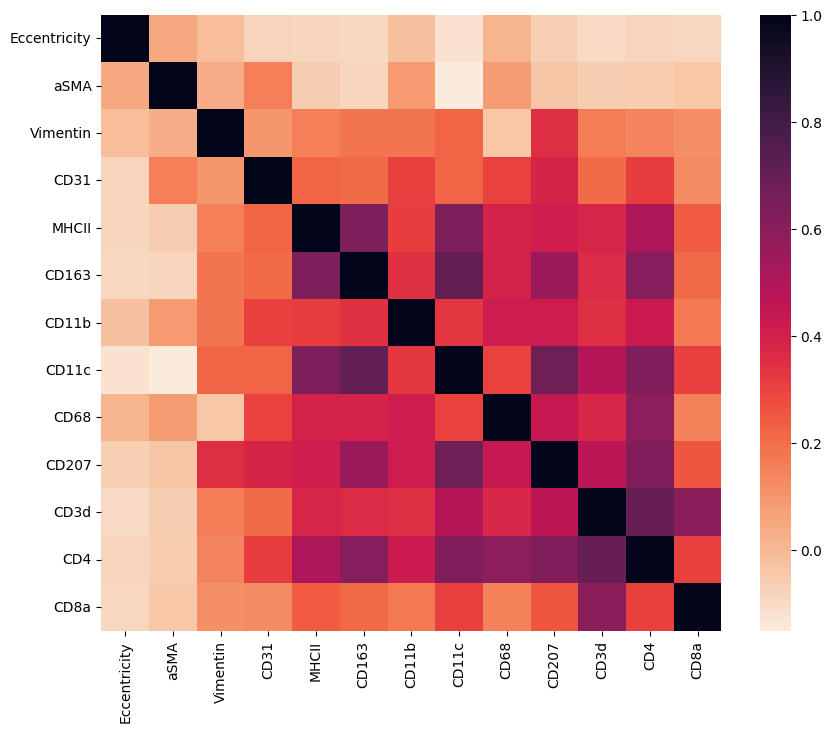

In [22]:
# check the marker correlation matrix we choose for the clustering method
marker_df = sample_data[logic["Global"]["Stromal1"].index]
plt.figure(figsize=(10,8))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [14]:
# Run Tribus on already z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=2, normalization=None) # modify depth

Global, subsetting done
CD4+Tcells, subsetting done
CD8+Tcells, subsetting done
less than min sample_size
13.32498238881429 minutes


<BarContainer object of 18 artists>

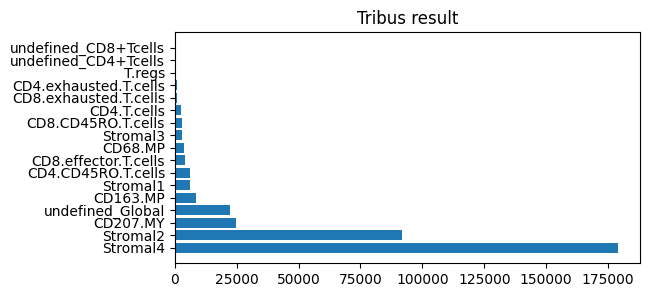

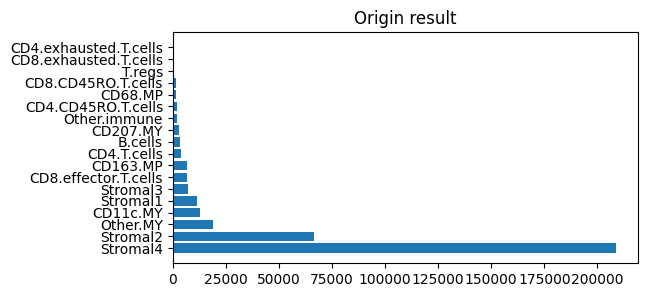

In [15]:
label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Tribus result')
ax.barh(name, num)

label_stat = pd.DataFrame({'Group': sample_data['GlobalCellType']})["Group"].value_counts().rename_axis('Group').reset_index(name='count')
name = label_stat['Group']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(6, 3))
plt.title('Origin result')
ax.barh(name, num)

              CD163.MP  CD207.MY  CD4+Tcells   CD68.MP  CD8+Tcells  Stromal1   
Eccentricity  0.512303  0.621108    0.565837  0.610265    0.597976  0.613808  \
aSMA          0.460188  0.451580    0.417851  0.445025    0.538311  0.684987   
Vimentin      0.661041  0.681418    0.588403  0.363280    0.660733  0.721906   
CD31          0.235330  0.257582    0.195916  0.205115    0.210836  0.805474   
MHCII         0.537477  0.408165    0.289843  0.304151    0.302917  0.256266   
CD163         0.737735  0.510157    0.423308  0.362968    0.359781  0.370501   
CD11b         0.569242  0.634091    0.561754  0.611677    0.551186  0.645893   
CD11c         0.537184  0.679294    0.559902  0.379570    0.403238  0.393255   
CD68          0.487060  0.534330    0.495209  0.559421    0.508056  0.539509   
CD207         0.664741  0.743090    0.681908  0.566930    0.616122  0.720111   
CD3d          0.460323  0.519999    0.619009  0.461347    0.764040  0.480647   
CD4           0.739307  0.756953    0.77

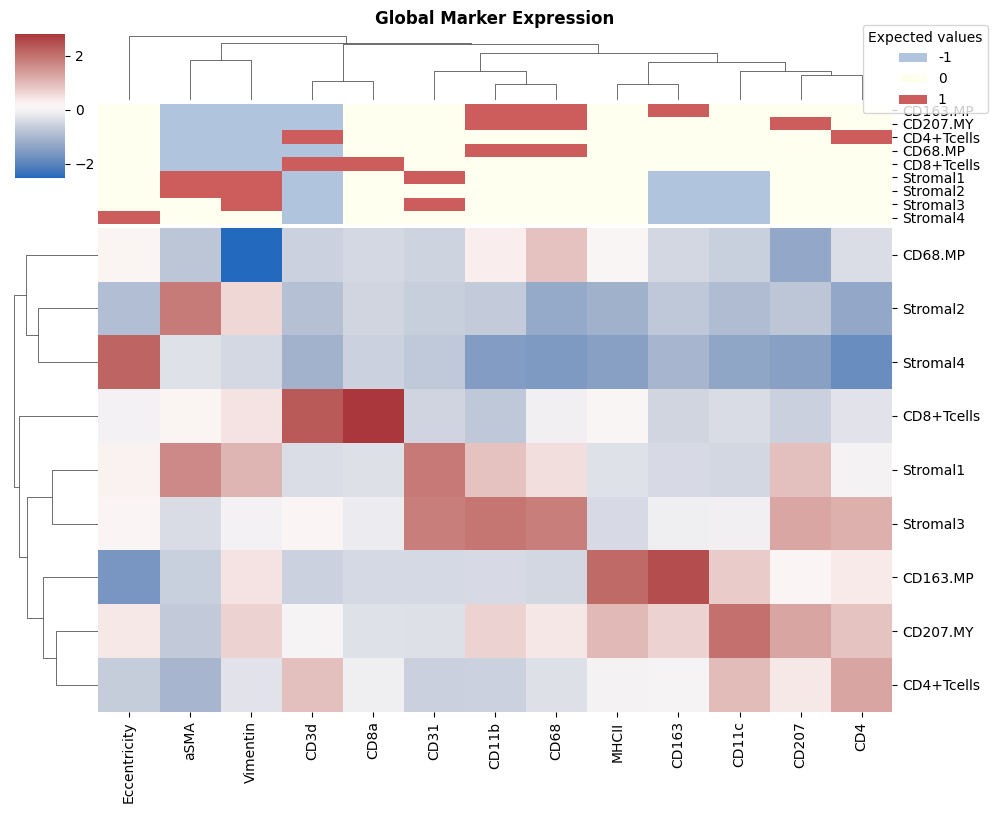

        CD4.CD45RO.T.cells  CD4.T.cells  CD4.exhausted.T.cells    T.regs
FOXP3             0.391369     0.292867               0.357640  0.782059
PD1               0.700056     0.621156               0.830354  0.720114
CD45RO            0.645779     0.360174               0.596825  0.700219
CD4               0.786899     0.716519               0.755902  0.859512


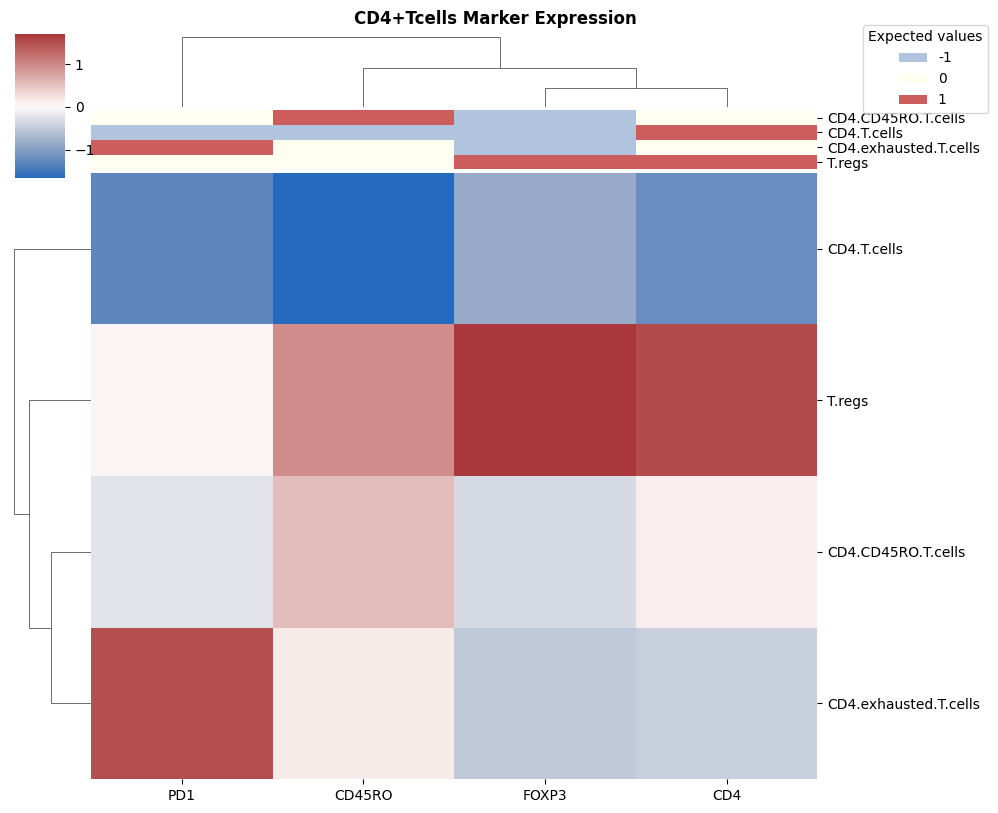

        CD8.CD45RO.T.cells  CD8.effector.T.cells  CD8.exhausted.T.cells
CD8a              0.758538              0.859503               0.828938
PD1               0.728091              0.671524               0.861707
CD45RO            0.743202              0.557614               0.629824


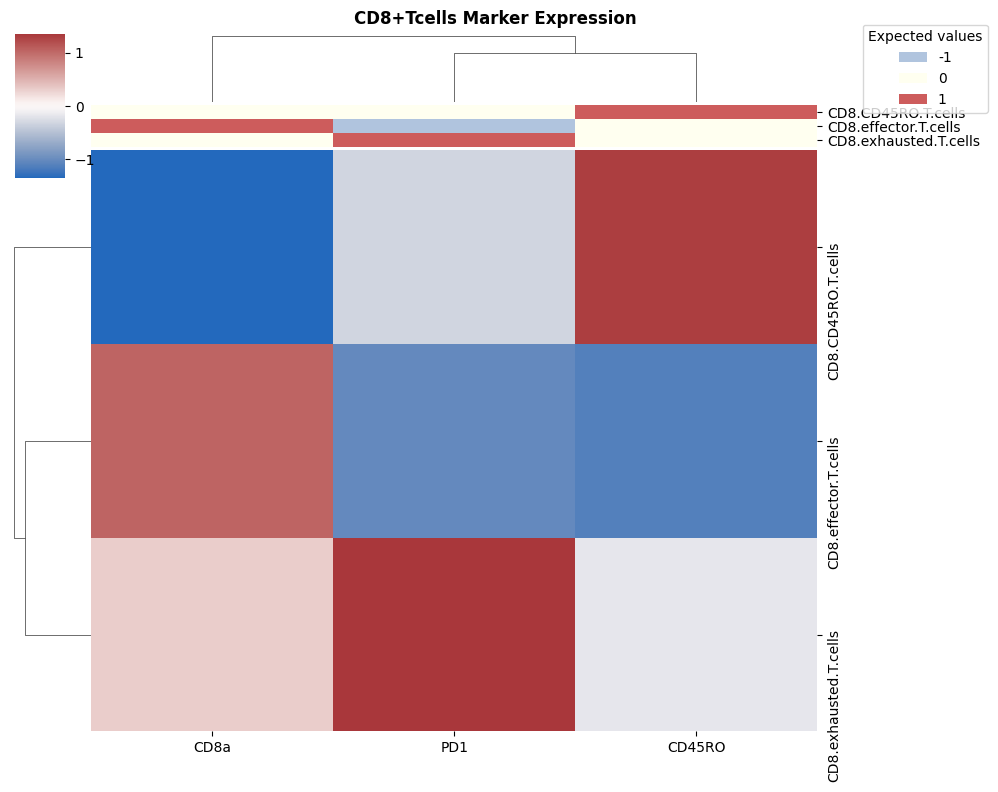

In [16]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False, fname=None,
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_22356\2941510773.py:18: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Text(158.08159722222223, 0.5, 'True')

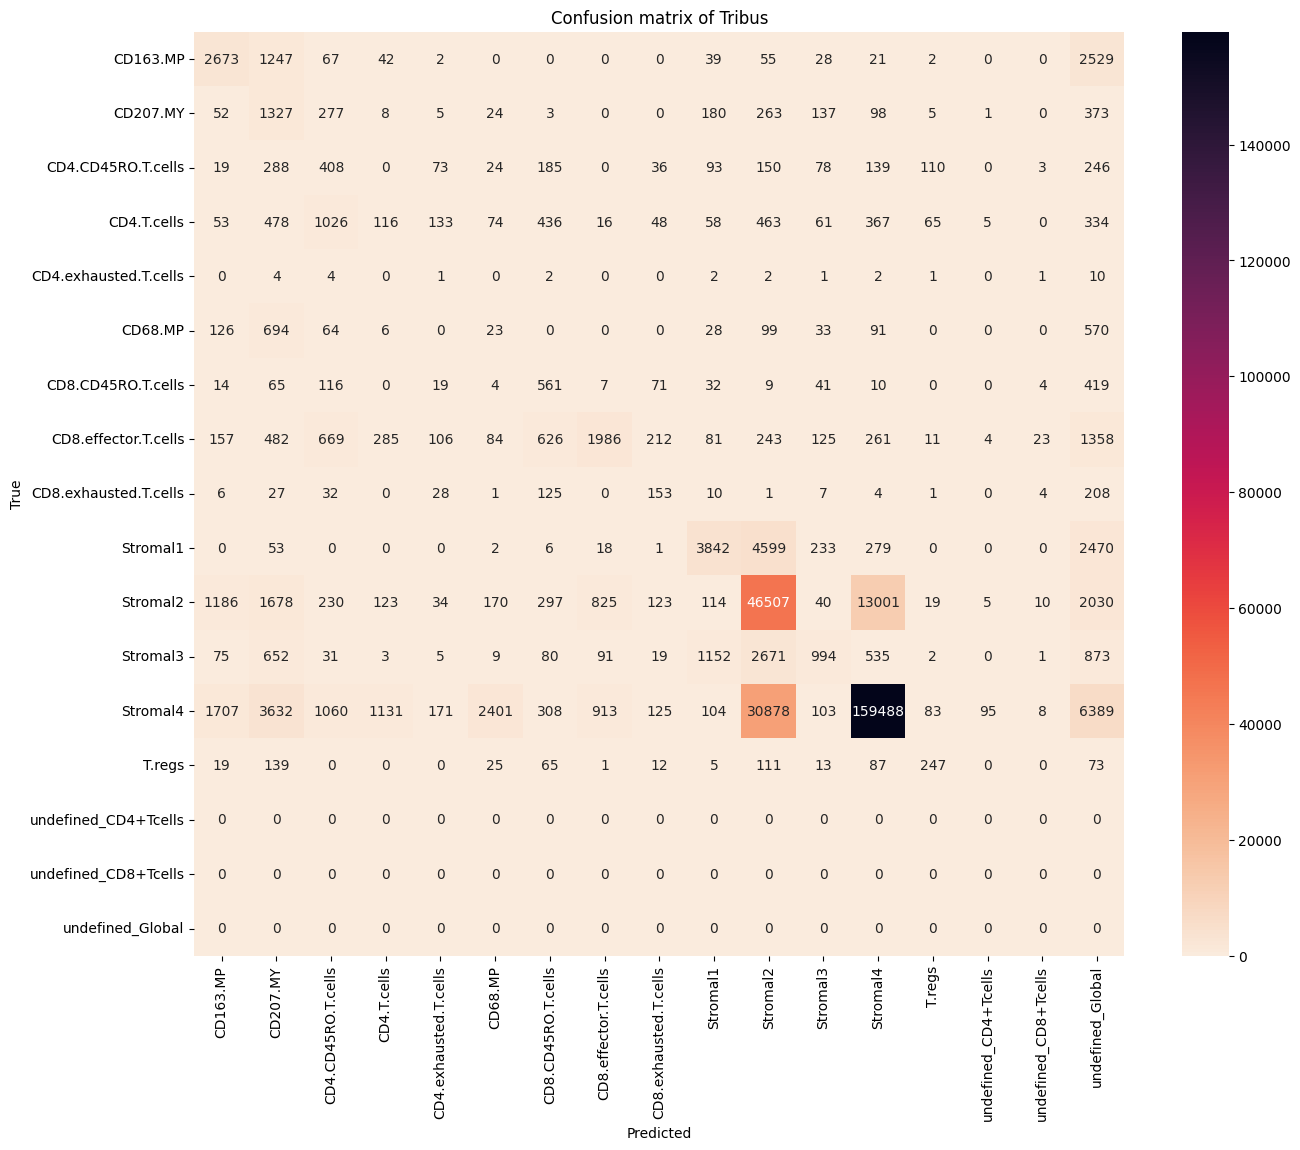

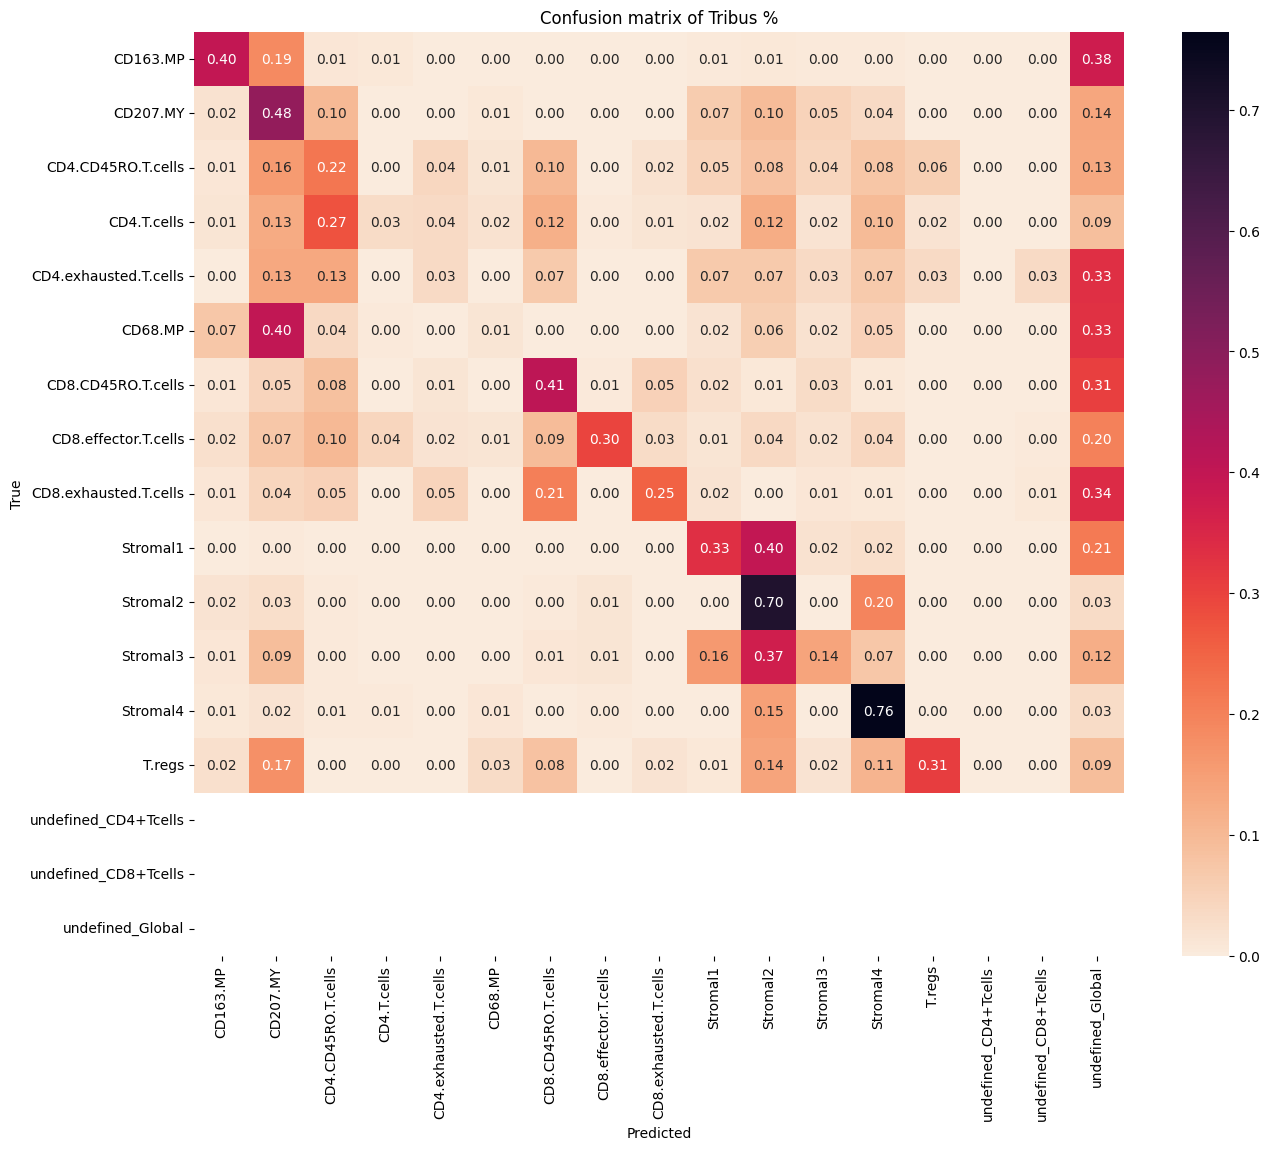

In [17]:
# confusion matrix
celltype_true = np.array(sample_data["GlobalCellType"]).tolist()
celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (15,12))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

In [20]:
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score
RI = rand_score(celltype_true, celltype_pred) #between 0-1
AS = accuracy_score(celltype_true, celltype_pred)
PS = precision_score(celltype_true, celltype_pred, average='weighted')
F1 = f1_score(celltype_true, celltype_pred, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI, AS, PS, F1))

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.7455077812085742, Accuracy score = 0.6111534111903616, Precision score = 0.6597147398006118, F1 score = 0.6252436246677188
